In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt
%matplotlib inline

In [2]:
# parameters
rho = 0.05 # discount rate
alpha = 0.3 # capital elasticity
delta = 0.1 # depreciation
theta = 1.0 # crra param

In [14]:
# algorithm
S0 = 4096 # max number of steps in perturbation simulation
K = 512 # size of capital grid
ptol = 1.0e-4 # initial displacement for perturbation simulation
dt_max = 1.0 # max time step in variable delt schemes

In [4]:
# steady state
k_ss = (alpha/(rho+delta))**(1.0/(1.0-alpha))
i_ss = delta*k_ss
y_ss = k_ss**alpha
c_ss = y_ss - i_ss

In [81]:
def simulate_ramsey(k0, c0, k_lo=0, k_hi=None, gk_targ=0.001, dt=None, direc=-1):
    # initial values
    k, c = k0, c0
    kpath, cpath = [k], [c]

    for t in range(S0):
        # growth rates
        gk = k**(alpha-1) - delta - c/k
        gc = (1/theta)*(alpha*k**(alpha-1)-(rho+delta))

        # adaptive step size
        dt1 = direc*np.minimum(dt_max, gk_targ/np.abs(gk)) if dt is None else dt
        k *= 1 + dt1*gk
        c *= 1 + dt1*gc

        # store
        kpath.append(k)
        cpath.append(c)

        # terminal condition
        if k_lo is not None and k <= k_lo:
            break
        if k_hi is not None and k >= k_hi:
            break

    return np.array(kpath), np.array(cpath)

In [82]:
# capital grid around steady state
k_lo, k_hi = 0.1*k_ss, 2.0*k_ss
k_grid = np.linspace(k_lo, k_hi, K)

# generate upper and lower paths
kvec1, cvec1 = simulate_ramsey(k_ss-ptol, c_ss-ptol, k_lo, k_hi)
kvec2, cvec2 = simulate_ramsey(k_ss+ptol, c_ss+ptol, k_lo, k_hi)

# combined path
kvec = np.concatenate([kvec1[::-1], kvec2])
cvec = np.concatenate([cvec1[::-1], cvec2])

# interpolate
cpol = interp.interp1d(kvec, cvec)
c_grid = cpol(k_grid)

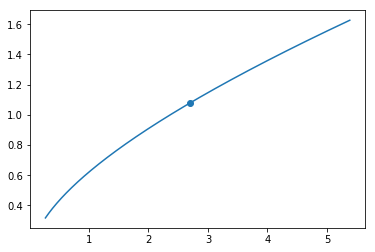

In [83]:
# plot results
fig, ax = plt.subplots()
ax.plot(k_grid, c_grid);
ax.scatter([k_ss], [c_ss]);

In [84]:
def forward_ramsey(k0, cf, dt=0.01, S=S0):
    # initial values
    k, c = k0, cf(k0)
    kpath, cpath = [k], [c]

    for t in range(S):
        # growth rates
        gk = k**(alpha-1) - delta - c/k

        # adaptive step size
        k *= 1 + dt*gk
        c = cf(k)

        # store
        kpath.append(k)
        cpath.append(c)

    return np.array(kpath), np.array(cpath)

In [85]:
def solow_policy(s):
    return lambda k: (1-s)*k**alpha

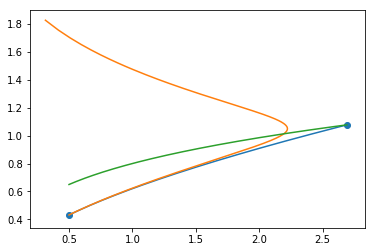

In [92]:
k0 = 0.5
c0 = float(cpol(k0))
c1 = c0

csol = solow_policy(0.2)

dt = 0.1
kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt)
ksol, csol = forward_ramsey(k0, csol, dt=dt)
ksim, csim = simulate_ramsey(k0, c1, dt=0.1, k_lo=0.4, direc=1)


fig, ax = plt.subplots()
ax.plot(kfwd, cfwd);
ax.plot(ksim, csim);
ax.plot(ksol, csol);
ax.scatter([k0, k_ss], [c0, c_ss]);